In [17]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Exam scores

In [14]:
scores = [ 21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 35] 
print(len(scores))

14


In [15]:
with pm.Model() as model:
    zi = pm.Bernoulli('zi', p=0.5, shape=len(scores))
    phi = pm.Uniform("phi", 0.5, 1, shape=len(scores))
    psi = 0.5
    theta = pm.Deterministic('theta',  pm.math.eq(zi, 1)*phi+pm.math.eq(zi, 0)*psi)
    
    pm.Binomial('obs', p=theta, n=40, observed=scores)
    traces = pm.sample(2000, tune=10000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [phi]
Sampling 4 chains, 0 divergences:  54%|█████▎    | 25710/48000 [00:10<00:09, 2391.95draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
pm.plot_posterior(traces["theta"][:, 0])

In [ ]:
(traces["theta"][:, 1] > 0.5).sum() / traces["theta"].shape[0]

# Exam scores with individual differences

In [ ]:
with pm.Model() as model:
    zi = pm.Bernoulli('zi', p=0.5, shape=len(scores))
    psi = 0.5
    tau = pm.Gamma('tau', alpha=0.001, beta=0.001 )
    mu = pm.Uniform('mu', 0.5, 1)
    phi = pm.Bound(pm.Normal, 0, 1)("phi", mu=mu, tau=tau, shape=len(scores))
    theta = pm.Deterministic("theta", pm.math.eq(zi,0)*psi + pm.math.eq(zi, 1)*phi )
    pm.Binomial('obs', p=theta, n=40, observed=scores)
    step = [pm.NUTS(target_accept=0.95, vars=[mu, phi, tau]), pm.BinaryGibbsMetropolis(vars=[zi])]
    traces = pm.sample(2000, tune=5000,  step=step, cores=2)

In [ ]:
pm.traceplot(traces)

In [ ]:
plt.figure()
thetapost = traces['theta']
plt.boxplot(thetapost);

## Mixture distribution

In [ ]:
pm.Binomial.dist(p=0.5, n=40, shape=len(scores)).mode
pm.Binomial.dist(p=sp, n=40, shape=len(scores)).mode

In [ ]:
with pm.Model() as mixture_model:
    w = pm.Dirichlet('w', a=np.ones(2))
    sp = pm.Uniform('sp', 0.5, 1, shape=len(scores))
    dist1 = pm.Binomial.dist(p=sp, n=40, shape=len(scores))
    dist2 = pm.Binomial.dist(p=[0.5]*len(scores), n=40, shape=len(scores))
    mixt = pm.Mixture('mixt', w=w, comp_dists=[dist1, dist2], observed=scores)
    traces = pm.sample(3000, tune=1000, cores=4)

In [ ]:
traces["sp"].shape

In [ ]:
pm.plot_posterior(traces, credible_interval=0.95)

In [ ]:
(traces["theta"][:, 5] > 0.5).sum() / traces["theta"].shape[0]

# Twenty Questions

In [ ]:
person_1 = [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1 , 0 , 0, 1, 0, 1, 0, 0 ]
person_2 = [0, 1, 1] + 17*[0]
person_3 = [0, 0, 1 , 0, 0, 0, 1,1]+12*[0]
person_4 = 6*[0]+[1, 0,1,1] + 10*[0]
person_5 = [1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0]
person_6 = [1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0]
person_7 = [0]*11+[1]+[0]*8
person_8 = [0]*20
person_9 = [0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1]
person_10= [1,0,0,0,0,0,1,0,0,1,0,0,1]+[0]*7
observed= np.stack([person_1, person_2, person_3, person_4, person_5, person_6, person_7, person_8, person_9, person_10]);observed.shape

In [ ]:
with pm.Model() as twenty_questions:
    people = pm.Beta('people', alpha=1, beta=1, shape=observed.shape[0])
    questions = pm.Beta('questions', alpha=1, beta=1, shape=observed.shape[1])
    ps = pm.Deterministic("pcorrect", tt.outer(people, questions))
    pm.Bernoulli('obs', p=ps, observed=observed)
    trace = pm.sample(3000, tune=1000, cores=4)

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
pipost = trace['people']
ax0.boxplot(pipost)

ax1 = plt.subplot(gs[1:])
qipost = trace['questions']
ax1.boxplot(qipost)

plt.tight_layout();

## Missing values


In [ ]:
person_1 = [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, -999 , 0 , 0, 1, 0, 1, 0, 0 ]
person_2 = [0, 1, 1] + 17*[0]
person_3 = [0, 0, 1 , 0, 0, 0, 1,1]+12*[0]
person_4 = 6*[0]+[1, 0,1,1] + 10*[0]
person_5 = [1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0]
person_6 = [1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0]
person_7 = [0]*11+[1]+[0]*8
person_8 = [0]*4+[-999]+[0]*15
person_9 = [0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1]
person_10= [1,0,0,0,0,0,1,0,0,1,0,0,1]+[0]*4+[-999]+[0,0]
missing_obs= np.stack([person_1, person_2, person_3, person_4, person_5, person_6, person_7, person_8, person_9, person_10]);observed.shape

In [ ]:
missing_obs = np.ma.masked_values(missing_obs, value=-999)

In [ ]:
with pm.Model() as twenty_questions:
    people = pm.Beta('people', alpha=1, beta=1, shape=observed.shape[0])
    questions = pm.Beta('questions', alpha=1, beta=1, shape=observed.shape[1])
    ps = pm.Deterministic("pcorrect", tt.outer(people, questions))
    pm.Bernoulli('obs', p=ps, observed=missing_obs)
    trace = pm.sample(3000, tune=1000, cores=4)

# Two Country Quiz

In [5]:
k = np.array([1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  0,1,1,0,0,1,0,0,
  0,1,1,0,0,1,1,0,
  1,0,0,1,1,0,0,1,
  0,0,0,1,1,0,0,1,
  0,1,0,0,0,1,1,0,
  0,1,1,1,0,1,1,0]).reshape(8,-1)

In [6]:
k.shape

(8, 8)

In [40]:
with pm.Model() as model:
    question_country = pm.Bernoulli("questions", p=0.5, shape=(1, k.shape[1]))
    user_country = pm.Bernoulli("users", p=0.5, shape=(k.shape[0], 1))
    within_country_success_rate = pm.Uniform("within_country_success_rate", 0, 1)
    outside_country_success_rate = pm.Uniform("outside_country_success_rate", 0, within_country_success_rate)
    
    p = pm.math.switch(tt.eq(user_country, question_country), within_country_success_rate, outside_country_success_rate)
    
    pm.Bernoulli('obs', p=p, observed=k)
    
    step = pm.Slice([question_country, user_country])
    traces = pm.sample(3000, tune=2000, cores=4,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [users]
>>Slice: [questions]
>NUTS: [outside_country_success_rate, within_country_success_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:27<00:00, 721.34draws/s]


In [48]:
traces["users"][:, 2].ravel().sum()

12000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e3d4de3d0>,
      dtype=object)

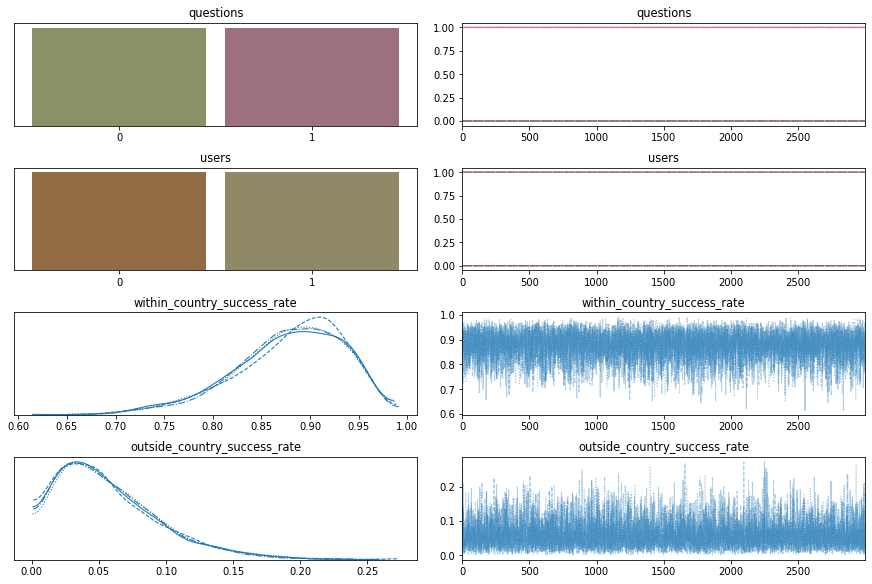

In [41]:
pm.traceplot(traces)

In [49]:
k = np.ma.masked_values([1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  0,1,1,0,0,1,0,0,
  0,1,1,0,0,1,1,0,
  1,0,0,1,1,0,0,1,
  0,0,0,1,1,0,0,1,
  0,1,0,0,0,1,1,0,
  0,1,1,1,0,1,1,0,
  1,0,0,1,-999,-999,-999,-999,
  0,-999,-999,-999,-999,-999,-999,-999,
  -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(11,-1)

In [50]:
k.shape

(11, 8)

In [ ]:
with pm.Model() as model:
    question_country = pm.Bernoulli("questions", p=0.5, shape=(1, k.shape[1]))
    user_country = pm.Bernoulli("users", p=0.5, shape=(k.shape[0], 1))
    within_country_success_rate = pm.Uniform("within_country_success_rate", 0, 1)
    outside_country_success_rate = pm.Uniform("outside_country_success_rate", 0, within_country_success_rate)
    
    p = pm.math.switch(tt.eq(user_country, question_country), within_country_success_rate, outside_country_success_rate)
    
    pm.Bernoulli('obs', p=p, observed=k)
    
    step = pm.Slice([question_country, user_country])
    traces = pm.sample(3000, tune=2000, cores=4, step=step)

/home/jvans/anaconda3/envs/py38/lib/python3.8/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e482ab280>,
      dtype=object)

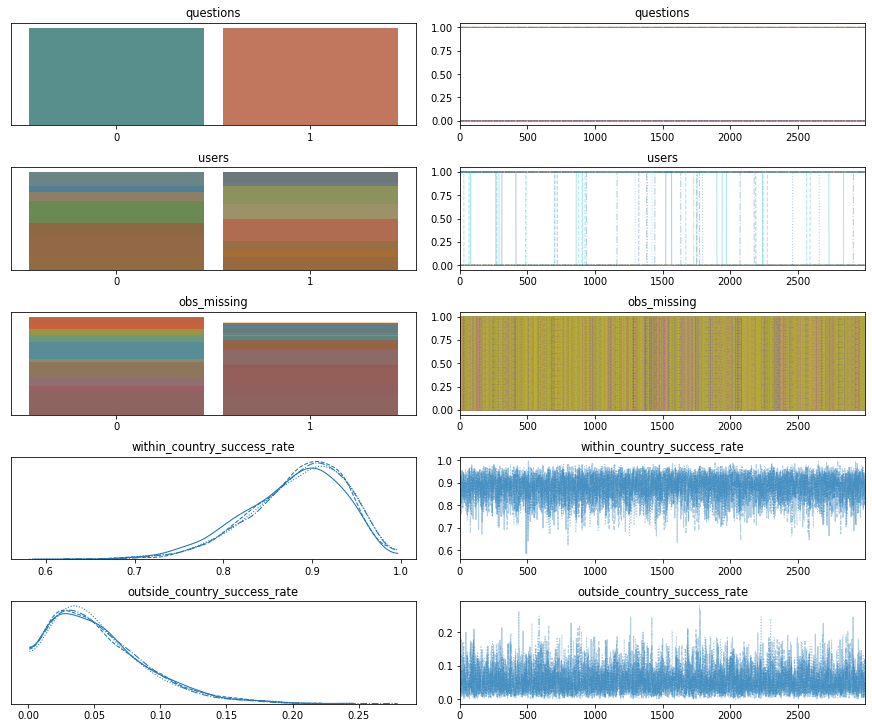

In [52]:
pm.traceplot(traces)

In [75]:
traces['users'][:, 9].ravel().sum()

7252

In [82]:
k = np.ma.masked_values([1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  1,0,0,1,1,0,0,1,
  0,1,1,0,0,1,0,0,
  0,1,1,0,0,1,1,0,
  1,0,0,1,1,0,0,1,
  0,0,0,1,1,0,0,1,
  0,1,0,0,0,1,1,0,
  0,1,1,1,0,1,1,0,
  1,0,0,1,-999,-999,-999,-999,
  0,-999,-999,-999,-999,-999,-999,-999,
  -999,-999,-999,-999,-999,-999,-999,-999], value=-999).reshape(21,-1)

In [ ]:
with pm.Model() as model:
    question_country = pm.Bernoulli("questions", p=0.5, shape=(1, k.shape[1]))
    
    phi = pm.Beta('phi', 2, 2)
    user_country = pm.Bernoulli("users", p=phi, shape=(k.shape[0], 1))
    within_country_success_rate = pm.Uniform("within_country_success_rate", 0, 1)
    outside_country_success_rate = pm.Uniform("outside_country_success_rate", 0, within_country_success_rate)
    
    p = pm.math.switch(tt.eq(user_country, question_country), within_country_success_rate, outside_country_success_rate)
    
    pm.Bernoulli('obs', p=p, observed=k)
    
    step = pm.Slice([question_country, user_country])
    traces = pm.sample(3000, tune=2000, cores=4, step=step)

In [87]:
k.shape

(21, 8)

In [90]:
traces['users'][:, 20].ravel().sum()

507

# Assessment of malingering 

In [42]:
k = np.array([45,45,44,45,44,45,45,45,45,45,30,20,6,44,44,27,25,17,14,27,35,30, 36])
k.shape

(23,)

In [93]:
with pm.Model() as model:
    
    category = pm.Bernoulli('category', p=0.5, shape=k.shape[0])
    
    p1 = pm.Uniform('honest', 0.5, 1)
    p2 = pm.Uniform('malinger', 0, p1)
    ps = pm.math.switch(pm.math.eq(category, 0), p1, p2)
    pm.Binomial('obs', p=ps, n=45, observed=k)
    traces = pm.sample(3000, tune=1500, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [category]
>NUTS: [malinger, honest]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:07<00:00, 2499.43draws/s]


In [98]:
traces['category'][:, 2].sum()

12000

In [43]:
with pm.Model() as model:
    # prior
    mub = pm.Beta('mub', alpha=1, beta=1)
    mud = pm.HalfNormal('mud', sd=.5)
    lambdab = pm.Uniform('lambdab', lower=40, upper=800)
    lambdam = pm.Uniform('lambdam', lower=4, upper=100)
    psi = pm.Beta('psi', alpha=5, beta=5)
    
    zi = pm.Bernoulli('zi', p=.1, shape=k.shape[0])
    
    mum = pm.Deterministic('mum', 1/(1+tt.exp(tt.log(1/mub-1)+mud)))
    theta1 = pm.Beta('theta1', alpha=mub*lambdab, beta=(1-mub)*lambdab)
    theta2 = pm.Beta('theta2', alpha=mum*lambdam, beta=(1-mum)*lambdam)
    
    theta = pm.Deterministic('theta', theta1*(tt.eq(zi, 0)) + theta2*(tt.eq(zi, 1)))
    
    # observed
    kij = pm.Binomial('kij', p=theta, n=45, observed=k)
    trace6 = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta2, theta1, psi, lambdam, lambdab, mud, mub]
>BinaryGibbsMetropolis: [zi]
Sampling 4 chains, 1 divergences: 100%|██████████| 6000/6000 [00:06<00:00, 990.27draws/s] 
The acceptance probability does not match the target. It is 0.8813464695472008, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [44]:
trace6["zi"][:, 22].sum() / 4000

0.9945

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa12b68f8b0>,
      dtype=object)

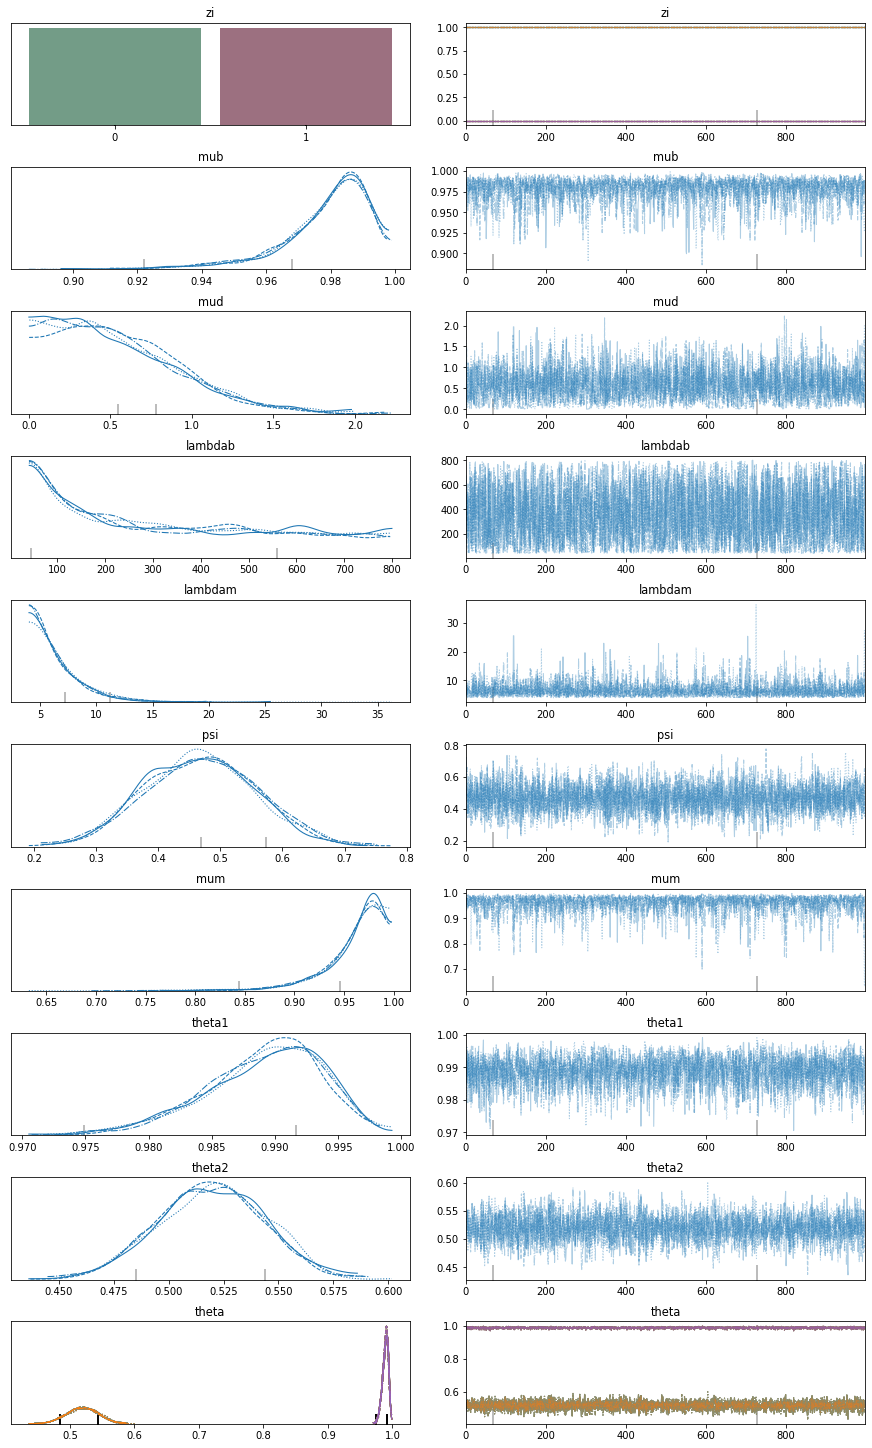

In [13]:
pm.traceplot(trace6)

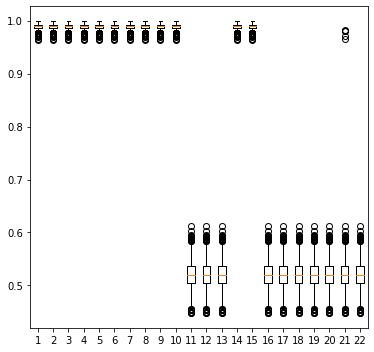

In [24]:
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
pipost = trace6['theta']
ax0.boxplot(pipost)

# ax1 = plt.subplot(gs[1:])
# qipost = trace6['questions']
# ax1.boxplot(qipost)

plt.tight_layout();

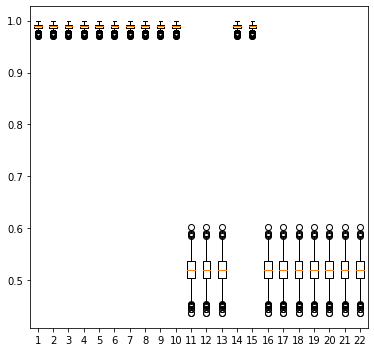

In [18]:
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 3) 
ax0 = plt.subplot(gs[0])
pipost = trace6['theta']
ax0.boxplot(pipost)

# ax1 = plt.subplot(gs[1:])
# qipost = trace6['questions']
# ax1.boxplot(qipost)

plt.tight_layout();